In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
base = '/Users/maxv/Dropbox (MIT)/inferring_expectations/'

In [85]:
from dateutil import parser
fire_db = pd.read_csv(base + 'data/gridmet_fire_ignitions.csv')
def parse_time(text):
    if text is None: return None
    if str(text) == 'NaT': return None
    text = text.split(' ')[0]
    return parser.parse(text, dayfirst=False)
fire_db['discovery_date'] = fire_db['discovery_date'].apply(parse_time)
fire_db['cont_date'] = fire_db['cont_date'].apply(parse_time)
fire_db['year'] = fire_db['discovery_date'].dt.year
fire_db.head()

,UniqueID,FIRE_SIZE,discovery_date,cont_date,LATITUDE,LONGITUDE,elevation,num_matches,utility,sph,...,vs_std,th_std,pet_std,etr_std,fm100_std,fm1000_std,bi_std,erc_std,pdsi_std,year
0,FPA_FS-1418826,0.10,2005-02-02,2005-02-02,40.036944,-121.005833,1169.0,1,PG&E,0.00285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005
1,FPA_FS-1418827,0.25,2004-05-12,2004-05-12,38.933056,-120.404444,1680.0,1,PG&E,0.00349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004
2,FPA_FS-1418835,0.10,2004-05-31,2004-05-31,38.984167,-120.735556,857.0,1,PG&E,0.00590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004
3,FPA_FS-1418845,0.10,2004-06-28,2004-07-03,38.559167,-119.913333,2408.0,1,PG&E,0.00437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004
4,FPA_FS-1418847,0.10,2004-06-28,2004-07-03,38.559167,-119.933056,2373.0,1,PG&E,0.00458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004


In [101]:
for quantity in ['total', 'mean']:
    if quantity == 'total':
        grouped = fire_db.groupby(['year','utility']).sum().reset_index()
    else: 
        grouped = fire_db.groupby(['year','utility']).mean().reset_index()
    grouped['log(total acres burned)'] = np.log10(grouped['FIRE_SIZE'])
    sns.lmplot(x='year',y='log(total acres burned)',hue='utility',data=grouped)
    plt.gca().set_ylabel('{} Fire Size (Acres)'.format(quantity.capitalize()))
    def format_func(value, tick_number):
        # find number of multiples of pi/2
        return r"$10^{ " + str(int(value)) + " }$"
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    plt.savefig(base + 'outputs/summary_stats/fire_size/{}_area_burned.png'.format(quantity), dpi=100, bbox_inches='tight')
    plt.close()

False

In [92]:
for utility in ['SCE','PG&E','SDG&E', 'all']:
    if utility == 'all':
        subset = fire_db[['year','FIRE_SIZE']]
    else:
        subset = fire_db[fire_db.utility == utility]
        subset = subset[['year','FIRE_SIZE']]
    # subset = subset[subset.FIRE_SIZE > 10]
    # subset = subset[subset.year < 2019]
    grouped = subset.groupby('year').count()
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(5,6))
    fig.tight_layout()
    for q in [0.1, 0.5, 0.7, 0.9, 0.995, 0.999, 1.0]:
        grouped['quantile {}'.format(q)] = np.log10(subset.groupby('year').quantile(q=q))
        sns.regplot(x='year', y='quantile {}'.format(q), data=grouped.reset_index(), label='{}%'.format(q * 100),
                   ax=ax[0]);
    #     plt.plot(grouped['quantile {}'.format(q)], label='{}%'.format(int(q * 100)))
    #     plt.line(grouped['quantile {}'.format(q)], label='{}%'.format(int(q * 100)))
    # plt.gca().set_yscale('log')
    ax[0].set_ylabel('Fire Size (Acres)')
    ax[0].set_xlabel('Year')
    def format_func(value, tick_number):
        # find number of multiples of pi/2
        return r"$10^{ " + str(int(value)) + " }$"
    ax[0].yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax[0].legend(loc='lower left');

    grouped = subset.groupby('year').count().reset_index()
    ax[1].plot(grouped['year'], grouped['FIRE_SIZE'])
    ax[1].set_ylabel('Number of Fires')
    plt.savefig(base + 'outputs/summary_stats/fire_size/fire_size_quantiles_{}.png'.format(utility), dpi=100, bbox_inches='tight')
    plt.close()

In [87]:
subset

,year,FIRE_SIZE
0,2005,0.10
1,2004,0.25
2,2004,0.10
3,2004,0.10
4,2004,0.10
...,...,...
265182,2021,NaN
265183,2021,1.10
265184,2021,NaN
265185,2021,NaN


In [35]:
nws = gpd.read_file(base + 'data/nws_gdb')
from datetime import datetime
def contime(text):
    """Convert text into a UTC datetime."""
    if text is None: return None
    # The 0000 is the standard VTEC undefined time
    if text.startswith("0000"):
        return None
    ts = datetime.strptime(text, "%Y%m%d%H%M")
    # NWS has a bug sometimes whereby 1969 or 1970s timestamps are emitted
    return ts
nws = nws[nws.PHENOM == 'FW']
nws['issued'] = nws['ISSUED'].apply(contime)
nws['expired'] = nws['EXPIRED'].apply(contime)
nws['init_exp'] = nws['INIT_EXP'].apply(contime)
nws['init_iss'] = nws['INIT_ISS'].apply(contime)
nws = nws.to_crs(epsg=2163)
nws.head()

,WFO,ISSUED,EXPIRED,INIT_ISS,INIT_EXP,PHENOM,GTYPE,SIG,ETN,STATUS,...,POLY_END,WINDTAG,HAILTAG,TORNTAG,DAMAGTAG,geometry,issued,expired,init_exp,init_iss
9811,STO,201007260000,201007260642,201007252009,201007261200,FW,C,W,2,CAN,...,None,NaN,NaN,None,None,"POLYGON ((-1724327.873 -568527.149, -1724574.4...",2010-07-26 00:00:00,2010-07-26 06:42:00,2010-07-26 12:00:00,2010-07-25 20:09:00
9812,LOX,201009260300,201009251610,201009241614,201009280400,FW,C,A,2,UPG,...,None,NaN,NaN,None,None,"POLYGON ((-1740530.663 -1015117.571, -1741649....",2010-09-26 03:00:00,2010-09-25 16:10:00,2010-09-28 04:00:00,2010-09-24 16:14:00
9813,MFR,201008171800,201008180400,201008162202,201008180400,FW,C,W,5,EXP,...,None,NaN,NaN,None,None,"POLYGON ((-1817974.743 -81926.945, -1823532.62...",2010-08-17 18:00:00,2010-08-18 04:00:00,2010-08-18 04:00:00,2010-08-16 22:02:00
9814,MFR,201008171800,201008162202,201008161041,201008180600,FW,C,A,5,UPG,...,None,NaN,NaN,None,None,"POLYGON ((-1817974.743 -81926.945, -1823532.62...",2010-08-17 18:00:00,2010-08-16 22:02:00,2010-08-18 06:00:00,2010-08-16 10:41:00
9815,MFR,201007251800,201007241757,201007222100,201007261200,FW,C,A,1,UPG,...,None,NaN,NaN,None,None,"POLYGON ((-1817974.743 -81926.945, -1823532.62...",2010-07-25 18:00:00,2010-07-24 17:57:00,2010-07-26 12:00:00,2010-07-22 21:00:00


In [18]:
nws.init_iss.dt.date

0         2012-11-30
1         2012-12-22
2         2012-12-02
3         2020-08-16
4         2016-01-06
             ...    
109174    2007-01-03
109175    2007-07-18
109176    2007-01-11
109177    2007-01-11
109178    2007-01-11
Name: init_iss, Length: 109179, dtype: object

/var/folders/10/m_drqhg91g179r68n5cmd1zw0000gn/T/ipykernel_99119/3147408939.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['year'] = fire_db['YEAR_'].astype(str)


,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry,alarm_date,year
0,2020,CA,CDF,NEU,NELSON,00013212,2020-06-18T00:00:00+00:00,2020-06-23T00:00:00+00:00,11.0,,110.0,109.602501,1.0,1.0,None,3252.523280,4.435447e+05,"MULTIPOLYGON (((-1825155.598 -442346.955, -182...",2020-06-18,2020
1,2020,CA,CDF,NEU,AMORUSO,00011799,2020-06-01T00:00:00+00:00,2020-06-04T00:00:00+00:00,2.0,,670.0,685.585022,1.0,1.0,None,9653.760308,2.774464e+06,"MULTIPOLYGON (((-1827382.489 -449811.591, -182...",2020-06-01,2020
2,2020,CA,CDF,NEU,ATHENS,00018493,2020-08-10T00:00:00+00:00,2020-03-01T00:00:00+00:00,14.0,,26.0,27.300480,1.0,1.0,None,1649.643235,1.104811e+05,"MULTIPOLYGON (((-1825092.198 -447504.359, -182...",2020-08-10,2020
3,2020,CA,CDF,NEU,FLEMING,00007619,2020-03-31T00:00:00+00:00,2020-04-01T00:00:00+00:00,9.0,,13.0,12.931550,1.0,1.0,None,1577.155857,5.233211e+04,"MULTIPOLYGON (((-1816946.545 -436067.986, -181...",2020-03-31,2020
4,2020,CA,CDF,NEU,MELANESE,00008471,2020-04-14T00:00:00+00:00,2020-04-19T00:00:00+00:00,18.0,,10.3,10.315960,1.0,1.0,None,1035.787625,4.174722e+04,"MULTIPOLYGON (((-1805143.642 -378533.509, -180...",2020-04-14,2020


In [38]:
pd.unique(nws.SIG)

array(['W', 'A'], dtype=object)

In [52]:
VTEC_SIGNIFICANCE = {
"W": "Warning",
"Y": "Advisory",
"A": "Watch",
"S": "Statement",
"O": "Outlook",
"N": "Synopsis",
"F": "Forecast",
}
warning_exists = []
fire_warnings = []
# Merging data into fire records
# Did the fire start in fire weather warning conditions? 
# Look at that distribution over time (since 2006 at least)
# What does this capture? Controlling for some significant weather variation, do we still see changes in fire size over time? 
# That's indicative of the overall extent of climate change, actually quite a bit. 
# Also plot how the distribution of fire dates has shifted - maybe have as a histogram on the bottom? (share of fires in which one) 
for i, row in fire_db.iterrows(): 
    date = row.alarm_date
    records_subset = nws[((nws.init_iss.dt.date <= date) | (nws.issued.dt.date <= date)) &\
                         ((nws.init_exp.dt.date >= date) | (nws.expired.dt.date >= date))]
    if len(records_subset) == 0: 
        fire_warnings.append(None)
        warning_exists.append(0)
        continue
    records_subset = records_subset[records_subset.intersects(row.geometry)]
    if len(records_subset) == 0: 
        fire_warnings.append(None)
        warning_exists.append(0)
        continue
    warnings=pd.unique(records_subset.SIG)
    warning_exists.append(1)
    if 'W' in warnings: 
        fire_warnings.append('W')
    elif 'Y' in warnings:
        fire_warnings.append('Y')
    elif 'A' in warnings:
        fire_warnings.append('A')
    elif 'S' in warnings:
        fire_warnings.append('S')
    else:
        assert False, "fire warning category not found"


In [53]:
fire_db['warning_exists'] = warning_exists
fire_db['warning_cat'] = fire_warnings

In [59]:
fire_db.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,...,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry,alarm_date,year,warning_exists,warning_cat
0,2020,CA,CDF,NEU,NELSON,00013212,2020-06-18T00:00:00+00:00,2020-06-23T00:00:00+00:00,11.0,,...,1.0,1.0,None,3252.523280,4.435447e+05,"MULTIPOLYGON (((-1825155.598 -442346.955, -182...",2020-06-18,2020,1,W
1,2020,CA,CDF,NEU,AMORUSO,00011799,2020-06-01T00:00:00+00:00,2020-06-04T00:00:00+00:00,2.0,,...,1.0,1.0,None,9653.760308,2.774464e+06,"MULTIPOLYGON (((-1827382.489 -449811.591, -182...",2020-06-01,2020,0,None
2,2020,CA,CDF,NEU,ATHENS,00018493,2020-08-10T00:00:00+00:00,2020-03-01T00:00:00+00:00,14.0,,...,1.0,1.0,None,1649.643235,1.104811e+05,"MULTIPOLYGON (((-1825092.198 -447504.359, -182...",2020-08-10,2020,0,None
3,2020,CA,CDF,NEU,FLEMING,00007619,2020-03-31T00:00:00+00:00,2020-04-01T00:00:00+00:00,9.0,,...,1.0,1.0,None,1577.155857,5.233211e+04,"MULTIPOLYGON (((-1816946.545 -436067.986, -181...",2020-03-31,2020,0,None
4,2020,CA,CDF,NEU,MELANESE,00008471,2020-04-14T00:00:00+00:00,2020-04-19T00:00:00+00:00,18.0,,...,1.0,1.0,None,1035.787625,4.174722e+04,"MULTIPOLYGON (((-1805143.642 -378533.509, -180...",2020-04-14,2020,0,None


In [58]:
np.mean(fire_db[fire_db.YEAR_.astype(int) >= 2019].warning_exists)

0.1958128078817734

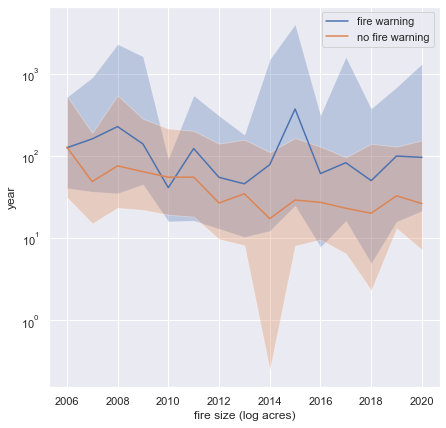

In [97]:
import seaborn as sns
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
subset = fire_db[['year','GIS_ACRES','warning_exists']]
subset = subset[subset.year >= 2006]
for cat in pd.unique(subset.warning_exists):
    sub_subset = subset[subset.warning_exists == cat]
    sub_subset = sub_subset.groupby('year').describe()
    x = sub_subset.index
    medians = sub_subset[('GIS_ACRES', '50%')]
    medians.name = 'burned acres'
    quartiles1 = sub_subset[('GIS_ACRES', '25%')]
    quartiles3 = sub_subset[('GIS_ACRES', '75%')]
    mins = sub_subset[('GIS_ACRES','min')]
    maxes = sub_subset[('GIS_ACRES','max')]
    plt.plot(x, medians, label="fire warning" if cat else "no fire warning") 
    ax.fill_between(x, quartiles1, quartiles3, alpha=0.3); 
#     ax.fill_between(x, mins, maxes, alpha=0.1); 
ax.legend();
plt.xlabel('fire size (log acres)')
plt.ylabel('year')
plt.show();
#     sns.lineplot(x='year',y='GIS_ACRES')
# sns.lineplot(x="year", y="GIS_ACRES",
#               ax=ax, hue='warning_exists',
#              data=fire_db[fire_db.year >= 2006])

In [80]:
sub_subset

GIS_ACRES                                                              \
         count         mean           std       min        25%         50%   
year                                                                         
2006     267.0  2448.326511  11952.379819  0.785785  31.774541  130.021362   
2007     252.0   978.380716   5495.988418  0.008896  15.218832   49.326839   
2008     297.0  2375.361305   8387.851787  0.090795  23.629000   76.700264   
2009     237.0  1037.027485   6531.208278  0.344524  22.270847   65.139656   
2010     190.0   464.328754   1769.589873  0.228372  19.479266   55.800440   
2011     270.0   473.887240   1883.572246  0.001532  18.405082   55.936705   
2012     319.0  2240.379829  18695.708787  0.042383   9.808575   27.092230   
2013     255.0  1052.791767   4172.357681  0.079019   8.254740   35.051228   
2014     194.0  1490.739223   8129.882331  0.093464   0.248776   17.442780   
2015     259.0  2209.982285  12490.548714  0.002612   8.164867   29.400000   
2016     327.0  1404.562040   8738.800858  0.053234   9.684818   27.593451   
2017     478.0   795.052450   5000.441749  0.002816   6.549804   23.347081   
2018     344.0  3082.410573  26309.965199  0.001515   2.332529   20.288637   
2019     255.0   542.286203   3634.261331  0.313640  13.262145   33.092155   
2020     397.0  2703.856433  22193.486311  1.009097   7.268880   26.626781   

                                warning_exists                                \
             75%            max          count mean  std  min  25%  50%  75%   
year                                                                           
2006  547.668274  161815.656250          267.0  0.0  0.0  0.0  0.0  0.0  0.0   
2007  193.854534   64959.957031          252.0  0.0  0.0  0.0  0.0  0.0  0.0   
2008  556.684631   76459.781250          297.0  0.0  0.0  0.0  0.0  0.0  0.0   
2009  288.136322   97815.312500          237.0  0.0  0.0  0.0  0.0  0.0  0.0   
2010  218.524605   16448.224609          190.0  0.0  0.0  0.0  0.0  0.0  0.0   
2011  205.524765   20681.539062          270.0  0.0  0.0  0.0  0.0  0.0  0.0   
2012  143.235535  315511.500000          319.0  0.0  0.0  0.0  0.0  0.0  0.0   
2013  160.441635   30267.691406          255.0  0.0  0.0  0.0  0.0  0.0  0.0   
2014  112.897909   97684.546875          194.0  0.0  0.0  0.0  0.0  0.0  0.0   
2015  167.827644  151546.812500          265.0  0.0  0.0  0.0  0.0  0.0  0.0   
2016  131.823929  132104.281250          327.0  0.0  0.0  0.0  0.0  0.0  0.0   
2017   97.969395   81826.273438          478.0  0.0  0.0  0.0  0.0  0.0  0.0   
2018  142.672012  410202.468750          344.0  0.0  0.0  0.0  0.0  0.0  0.0   
2019  131.703049   54614.902344          255.0  0.0  0.0  0.0  0.0  0.0  0.0   
2020  157.114899  379882.250000          398.0  0.0  0.0  0.0  0.0  0.0  0.0   

           
      max  
year       
2006  0.0  
2007  0.0  
2008  0.0  
2009  0.0  
2010  0.0  
2011  0.0  
2012  0.0  
2013  0.0  
2014  0.0  
2015  0.0  
2016  0.0  
2017  0.0  
2018  0.0  
2019  0.0  
2020  0.0

In [77]:
fire_db.groupby(['year']).describe()

CAUSE                                                    REPORT_AC  \
      count       mean       std   min   25%   50%   75%   max     count   
year                                                                       
1878    1.0  14.000000       NaN  14.0  14.0  14.0  14.0  14.0       0.0   
1895    1.0  14.000000       NaN  14.0  14.0  14.0  14.0  14.0       0.0   
1896    1.0  14.000000       NaN  14.0  14.0  14.0  14.0  14.0       0.0   
1898    5.0  14.000000  0.000000  14.0  14.0  14.0  14.0  14.0       0.0   
1900   12.0  14.000000  0.000000  14.0  14.0  14.0  14.0  14.0       0.0   
...     ...        ...       ...   ...   ...   ...   ...   ...       ...   
2016  352.0   9.511364  4.769906   1.0   6.0  10.0  14.0  18.0     330.0   
2017  607.0   8.108731  5.248735   1.0   2.0   9.0  14.0  14.0     452.0   
2018  410.0   9.456098  4.995281   1.0   5.0  11.0  14.0  18.0     338.0   
2019  309.0   7.889968  5.287285   1.0   2.0   9.0  14.0  18.0     238.0   
2020  500.0   8.308000  5.211473   1.0   2.0   9.5  14.0  18.0     442.0   

                   ...    Shape_Area               warning_exists            \
             mean  ...           75%           max          count      mean   
year               ...                                                        
1878          NaN  ...  2.406620e+08  2.406620e+08            1.0  0.000000   
1895          NaN  ...  2.541886e+06  2.541886e+06            1.0  0.000000   
1896          NaN  ...  3.047978e+07  3.047978e+07            1.0  0.000000   
1898          NaN  ...  1.203772e+07  8.312223e+07            5.0  0.000000   
1900          NaN  ...  4.286320e+06  6.863669e+07           12.0  0.000000   
...           ...  ...           ...           ...            ...       ...   
2016  1592.475413  ...  5.806634e+05  5.346071e+08          352.0  0.071023   
2017  2110.461935  ...  5.843234e+05  1.140367e+09          607.0  0.212521   
2018  4098.175784  ...  7.373192e+05  1.660030e+09          413.0  0.167070   
2019   798.549882  ...  6.967007e+05  3.146922e+08          312.0  0.182692   
2020  5398.385887  ...  9.349456e+05  4.179187e+09          500.0  0.204000   

                                         
           std  min  25%  50%  75%  max  
year                                     
1878       NaN  0.0  0.0  0.0  0.0  0.0  
1895       NaN  0.0  0.0  0.0  0.0  0.0  
1896       NaN  0.0  0.0  0.0  0.0  0.0  
1898  0.000000  0.0  0.0  0.0  0.0  0.0  
1900  0.000000  0.0  0.0  0.0  0.0  0.0  
...        ...  ...  ...  ...  ...  ...  
2016  0.257228  0.0  0.0  0.0  0.0  1.0  
2017  0.409429  0.0  0.0  0.0  0.0  1.0  
2018  0.373491  0.0  0.0  0.0  0.0  1.0  
2019  0.387035  0.0  0.0  0.0  0.0  1.0  
2020  0.403373  0.0  0.0  0.0  0.0  1.0  

[123 rows x 64 columns]

In [69]:
pd.unique(fire_db.year)

array([2020, 2007, 2005, 2004, 1944, 1915, 1917, 1960, 1921, 1923, 1970,
       1920, 1979, 1990, 1998, 1966, 1942, 1941, 1982, 1973, 1977, 1953,
       1946, 1955, 1931, 1949, 1964, 1948, 1958, 1972, 1916, 1974, 1950,
       1930, 1971, 1924, 1926, 1927, 1945, 1952, 1911, 1929, 1997, 2006,
       1984, 1910, 1951, 1956, 1981, 1909, 1935, 1936, 1961, 1919, 1925,
       1928, 1918, 1940, 1933, 1968, 1999, 1943, 1914, 1922, 1975, 1932,
       1912, 1978, 1983, 1913, 1947, 1934, 1937, 1938, 1967, 1976, 2000,
       1994, 1954, 1878, 1895, 1896, 1898, 1907, 1908, 1986, 1980, 1962,
       1959, 1900, 1957, 2003, 1969, 1988, 1996, 1991, 1992, 1995, 1987,
       1939, 2001, 1903, 1905, 1906, 1985, 1989, 2002, 1965, 1993, 1963,
       2008, 2010, 2016, 2012, 2014, 1902, 2009, 2011, 2013, 2015, 2017,
       2018, 2019])

In [73]:
fire_db.GIS_ACRES

0         109.602501
1         685.585022
2          27.300480
3          12.931550
4          10.315960
            ...     
21313       6.297734
21314       8.482671
21315      64.888229
21316      66.587181
21317    8799.325195
Name: GIS_ACRES, Length: 21241, dtype: float64

In [128]:
from datetime import datetime
def contime(text):
    """Convert text into a UTC datetime."""
    # The 0000 is the standard VTEC undefined time
    if text.startswith("0000"):
        return None
    ts = datetime.strptime(text, "%Y%m%d%H%M")
    # NWS has a bug sometimes whereby 1969 or 1970s timestamps are emitted
    return ts
nws['issued'] = nws['ISSUED'].apply(contime)
nws['expired'] = nws['EXPIRED'].apply(contime)

In [150]:
pd.unique(nws[nws.issued.dt.year <= 2007].PHENOM)

array(['SV', 'MA', 'FF', 'TO', 'WI', 'EH', 'FG', 'FW', 'FR', 'HT', 'HW',
       'FA', 'FZ', 'DU', 'SN', 'SU', 'CF', 'HS', 'WS', 'WW', 'SB', 'ZR',
       'WC', 'LW', 'SM', 'BS', 'LE', 'ZF', 'DS', 'AS', 'HZ'], dtype=object)

In [21]:
fire_db = gpd.read_file(base + 'data/fire20_1.gdb')
fire_db.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry
0,2020,CA,CDF,NEU,NELSON,00013212,2020-06-18T00:00:00+00:00,2020-06-23T00:00:00+00:00,11.0,,110.0,109.602501,1.0,1.0,None,3252.523280,4.435447e+05,"MULTIPOLYGON (((-116841.251 97942.565, -116836..."
1,2020,CA,CDF,NEU,AMORUSO,00011799,2020-06-01T00:00:00+00:00,2020-06-04T00:00:00+00:00,2.0,,670.0,685.585022,1.0,1.0,None,9653.760308,2.774464e+06,"MULTIPOLYGON (((-117328.400 90212.407, -117321..."
2,2020,CA,CDF,NEU,ATHENS,00018493,2020-08-10T00:00:00+00:00,2020-03-01T00:00:00+00:00,14.0,,26.0,27.300480,1.0,1.0,None,1649.643235,1.104811e+05,"MULTIPOLYGON (((-115605.059 92988.787, -115585..."
3,2020,CA,CDF,NEU,FLEMING,00007619,2020-03-31T00:00:00+00:00,2020-04-01T00:00:00+00:00,9.0,,13.0,12.931550,1.0,1.0,None,1577.155857,5.233211e+04,"MULTIPOLYGON (((-110213.270 105975.579, -11020..."
4,2020,CA,CDF,NEU,MELANESE,00008471,2020-04-14T00:00:00+00:00,2020-04-19T00:00:00+00:00,18.0,,10.3,10.315960,1.0,1.0,None,1035.787625,4.174722e+04,"MULTIPOLYGON (((-111793.600 164243.615, -11177..."


In [93]:
subset = fire_db[['YEAR_','REPORT_AC']]
subset['year'] = fire_db['YEAR_'].astype(str)
subset = subset[[x.isnumeric() for x in subset.year]]
subset['year'] = subset['year'].astype(int)
subset = subset[subset.year >= 1950]

/var/folders/10/m_drqhg91g179r68n5cmd1zw0000gn/T/ipykernel_76887/4102070806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['year'] = fire_db['YEAR_'].astype(str)


/var/folders/10/m_drqhg91g179r68n5cmd1zw0000gn/T/ipykernel_76887/1130066837.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  grouped['quantile {}'.format(q)] = subset.groupby('year').quantile(q=q)


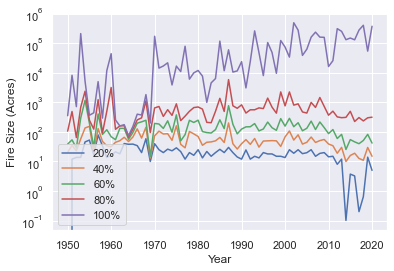

In [106]:
grouped = subset.groupby('year').count()
for q in [0.2, 0.4, 0.6, 0.8, 1.0]:
    grouped['quantile {}'.format(q)] = subset.groupby('year').quantile(q=q)
    plt.plot(grouped['quantile {}'.format(q)], label='{}%'.format(int(q * 100)))
plt.gca().set_yscale('log')
plt.ylabel('Fire Size (Acres)')
plt.xlabel('Year')
plt.gca().legend(loc='lower left');

In [108]:
grouped.tail(10)

,YEAR_,REPORT_AC,quantile 0.2,quantile 0.4,quantile 0.6,quantile 0.8,quantile 1.0
year,,,,,,,
2011,317,260,15.000000,34.200,120.40,506.000000,25938.0
2012,351,337,8.042000,19.000,60.00,323.600000,315577.0
2013,298,220,12.000000,30.000,82.80,304.200000,255858.0
2014,238,211,0.100826,10.000,25.50,312.289429,133284.2
2015,318,263,3.732866,15.940,55.00,500.000000,151623.0
2016,352,330,3.240000,19.012,46.16,226.000000,132127.0
2017,607,452,0.200000,12.660,40.00,307.200000,281893.0
2018,413,338,0.640000,11.000,51.42,236.400000,410203.0
2019,312,238,14.000000,29.800,82.92,301.600000,54628.0


In [22]:
len(fire_db[fire_db.CAUSE == 11])

412

In [19]:
perim_db = gpd.read_file(base + 'data/Wildfire_Perimeters')
# perim_db['year'] = pd.to_datetime(perim_db['Fire Discovery Date Time']).dt.year
perim_db.head()

,OBJECTID,poly_Incid,poly_Featu,poly_MapMe,poly_GISAc,poly_Creat,poly_DateC,poly_Polyg,poly_Acres,poly_Globa,...,irwin_Stra,irwin_Glob,irwin_Sour,irwin_Arch,irwin_Mo_1,irwin_Cr_1,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,136,Beach,Wildfire Daily Fire Perimeter,Mixed Methods,0.93000,2021-05-04,2021-05-04,None,0.934468,{ACB5D2C6-9B76-4E5D-994F-F0C852A728C5},...,None,None,IRWIN,None,2021-03-27,2021-03-07,{BA4D59C9-E0D0-4B4C-9D7F-C6CFC3E415EB},0.004170,-3.709994e-07,"POLYGON ((-114.37222 34.45594, -114.37271 34.4..."
1,142,MCCLUNG,Wildfire Daily Fire Perimeter,Auto-generated,1.00000,2021-05-04,2021-05-04,2021-03-21,1.390694,{6EB5CD0D-F677-4C9A-B523-69812F710975},...,None,None,IRWIN,None,2021-04-19,2021-03-21,{6DADBF15-B10E-409E-9E1F-9C7518884BCA},0.002975,-5.530848e-07,"POLYGON ((-98.68619 34.60254, -98.68622 34.602..."
2,167,MARTIN,Wildfire Daily Fire Perimeter,Auto-generated,0.10000,2021-05-04,2021-05-04,2021-03-09,91.819411,{A4978030-5D1A-40D9-9FDE-A00629509FCE},...,None,None,IRWIN,None,2021-03-10,2021-03-10,{96ED9BB2-C6FE-4C15-A6E3-2F46E6156FA3},0.024896,-3.667562e-05,"POLYGON ((-95.10353 34.96360, -95.10339 34.967..."
3,173,Oregon Basin,Wildfire Daily Fire Perimeter,GPS-Walked,16.50000,2021-06-17,2021-06-17,2021-02-03,18.668341,{0F077EB2-A6BE-4C28-9A0B-ABED2A6CB75E},...,None,None,IRWIN,None,2021-06-17,2021-01-30,{319961A9-67EC-46ED-A348-F97C13B425BD},0.014402,-8.525697e-06,"POLYGON ((-108.91493 44.34145, -108.91495 44.3..."
4,197,Wetlands,Wildfire Daily Fire Perimeter,Mixed Methods,44.85459,2021-05-04,2021-05-04,None,44.854462,{3FAB44AD-1DE2-4410-BB97-227C99D7FED3},...,None,None,IRWIN,None,2021-08-03,2021-02-18,{B0D4087C-93A5-4043-89D6-D0585D89DDF9},0.022710,-1.816797e-05,"POLYGON ((-115.02866 36.10424, -115.02870 36.1..."


In [17]:
list(perim_db)

['OBJECTID',
 'poly_Incid',
 'poly_Featu',
 'poly_MapMe',
 'poly_GISAc',
 'poly_Creat',
 'poly_DateC',
 'poly_Polyg',
 'poly_Acres',
 'poly_Globa',
 'poly_Sourc',
 'irwin_ABCD',
 'irwin_ADSP',
 'irwin_Calc',
 'irwin_Cont',
 'irwin_Co_1',
 'irwin_Dail',
 'irwin_Disc',
 'irwin_Disp',
 'irwin_Esti',
 'irwin_FFRe',
 'irwin_FF_1',
 'irwin_FF_2',
 'irwin_Fire',
 'irwin_Fi_1',
 'irwin_Fi_2',
 'irwin_Fi_3',
 'irwin_Fi_4',
 'irwin_Fi_5',
 'irwin_Fi_6',
 'irwin_Fi_7',
 'irwin_Fi_8',
 'irwin_Fi_9',
 'irwin_Fi10',
 'irwin_Fi11',
 'irwin_FSCo',
 'irwin_FSFu',
 'irwin_FSMo',
 'irwin_FSPo',
 'irwin_FSJo',
 'irwin_FSOv',
 'irwin_GACC',
 'irwin_ICS2',
 'irwin_IC_1',
 'irwin_IC_2',
 'irwin_IC_3',
 'irwin_Inci',
 'irwin_In_1',
 'irwin_In_2',
 'irwin_In_3',
 'irwin_In_4',
 'irwin_Init',
 'irwin_In_5',
 'irwin_In_6',
 'irwin_In_7',
 'irwin_Irwi',
 'irwin_IsFi',
 'irwin_Is_1',
 'irwin_IsFS',
 'irwin_IsMu',
 'irwin_IsRe',
 'irwin_IsTr',
 'irwin_IsUn',
 'irwin_Loca',
 'irwin_Perc',
 'irwin_Pe_1',
 'irwin_POOC

In [52]:
pd.read_csv(base + 'data/CPUC_fire_reports/fires_2014_2020.csv').head()


,Unnamed: 0,Utility Name,Date,Time,Latitude,Longitude,Material at Origin,Land Use at Origin,Size,Suppressed by,...,Outage date,Outage time,Suspected Initiating Event,Equipment /Facility Failure,Contact From Object,Facility Contacted,Contributing Factor,Notes,Notes_2,Circuit
0,3.0,SDG&E,1/1/14,18:45,33.1179,-117.078,Vegetation,Urban,Less Than .25 Acres,Customer,...,1/1/14,18:45,Equipment/Facility Failure,Splice/Clamp/Connector,Vehicle,Pole,Other,NaN,NaN,NaN
1,4.0,SDG&E,3/5/14,9:49,33.2038,-117.1142,Vegetation,Rural,.26 - 9.99 Acres,Fire Agency,...,3/12/14,9:49,Equipment/Facility Failure,Splice/Clamp/Connector,Other,NaN,NaN,NaN,NaN,NaN
2,5.0,SDG&E,4/15/14,6:20,32.6778,-117.046,Vegetation,Urban,Less Than .25 Acres,Fire Agency,...,NaN,NaN,Equipment/Facility Failure,Guy/Span Wire,Other,Electric Facility,None,NaN,NaN,NaN
3,6.0,SDG&E,4/17/14,16:42,33.2203,-117.338,Vegetation,Urban,Less Than .25 Acres,Fire Agency,...,NaN,NaN,Contact From Object,NaN,Vehicle,Electric Facility,Human Error,NaN,NaN,NaN
4,7.0,SDG&E,4/27/14,12:00,32.2415,-117.347,Vegetation,Rural,Less Than .25 Acres,Utility,...,NaN,NaN,Equipment/Facility Failure,Other,Vehicle,Pole,None,NaN,NaN,NaN


In [11]:
fire_db.shape

(21318, 18)

In [50]:
db = pd.read_csv(base + 'data/CPUC_fire_reports/SCE Fire Report 2020.csv')
def read_distribution(x):
    x = x.lower()
    if 'distrib' in x:
        return 'distribution'
    if 'transmis' in x:
        return 'transmission'
db['line_type'] = db['type'].apply(read_distribution)
db['Equipment Involved With Ignition'] = db['type'].apply(lambda x: x.split(' ')[1])
def arg_if_there(x, arg):
    if len(x.split(' ')) > arg:
        return x.split(' ')[arg]
    else:
        return np.nan

db['Type'] = np.where([len(y) > 2 for y in db['type'].apply(lambda x: x.split(' '))],
                     db['type'].apply(lambda x: arg_if_there(x,2)), 
                      db['Was There Date'].astype(str).apply(lambda x: x.split(' ')[0]))
db['Was there an outage'] = np.where([len(y) > 0 for y in db['Outage date'].astype(str)],
                                    'Yes','No')
db['Suspected Initiating Event'] = None
db['Equipment /Facility Failure'] = None
db['Contact From Object'] = None
db['Notes'] = None
db[['Utility Name','Date','Time','Latitude','Longitude','Material','Land use','Size','Suppressed By','Suppressing Agency',
  'Facility Identification','Other Companies','Voltage','Equipment Involved With Ignition','Type','Was there an outage',
   'Outage date','outage time','Suspected Initiating Event','Equipment /Facility Failure',
   'Contact From Object','Facility Contacted','Contributing Factor','Notes','Circuit']].to_csv(base + 'data/CPUC_fire_reports/SCE_2020_cleanish.csv')

In [49]:
list(db)

['Utility Name',
 'Date',
 'Time',
 'Latitude',
 'Longitude',
 'Material',
 'Land use',
 'Size',
 'Suppressed By',
 'Suppressing Agency',
 'Facility Identification',
 'Other Companies',
 'Voltage',
 'type',
 'Was There Date',
 'HFRA',
 'cGIS HFRA HFTD',
 'Unnamed: 17',
 'Outage date',
 'outage time',
 'suspected equipment',
 'Contributing Factor',
 'Facility Contacted',
 'Circuit',
 'FIPA Form Name',
 'line_type',
 'Equipment Involved With Ignition',
 'Type',
 'Was there an outage',
 'Suspected Initiating Event',
 'Equipment /Facility Failure',
 'Contact From Object',
 'Notes']

In [43]:
'Utility Name	Date	Time	Latitude	Longitude	Material at Origin	Land Use at Origin	Size	Suppressed by	Suppressing Agency	Facility Identification	Other Companies	Voltage	Equipment Involved With Ignition	Type	Was There an Outage	Outage date	Outage time	Suspected Initiating Event	Equipment /Facility Failure	Contact From Object	Facility Contacted	Contributing Factor	Notes'.split('\t')

,Type,type
0,Overhead,Distributio Other
1,Overhead,Distributio Conductor Overhead Yes
2,Overhead,Distributio Other
3,Overhead,Distributio Conductor Overhead No
4,Overhead,Distributio Conductor Overhead Yes
...,...,...
144,Overhead,Distributio Conductor Overhead No
145,Overhead,Distributio Fuse
146,A,Distributio Lightning A Overhead Yes
147,Overhead,Distributio Conductor Overhead Yes
